# **Final XGBoost work**

## 1) Loading Data and Packages + Util



In [22]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score, auc
import matplotlib.pyplot as plt
from typing_extensions import final
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from scipy.stats import trim_mean

Load data from local folder

In [9]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving user_flat.csv to user_flat.csv
Saving two_week_flat.csv to two_week_flat.csv


Setup fitbit_data

In [3]:
user_level = pd.read_csv('/content/data/user_level.csv')

/tmp/ipython-input-3-1036926836.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  user_level = pd.read_csv('/content/data/user_level.csv')


In [4]:
week_level = pd.read_csv('/content/data/week_level.csv')

/tmp/ipython-input-4-2491544649.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  week_level = pd.read_csv('/content/data/week_level.csv')


In [15]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'visit_day'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_features = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']

In [6]:
def compute_metrics(y_true, y_prob, thresh: float = 0.5):
    y_pred = (y_prob > thresh).astype(int)
    auroc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true,y_pred)
    cm = confusion_matrix(y_true,y_pred)

    return acc, auroc, auprc, cm

In [7]:
week_level

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
0,0,2021-07-27,App Money,1,228.619094,0.737880,0.065994,0.133897,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,2021-07-28,App Money,1,227.560876,1.156854,0.065994,1.277414,270.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,2021-07-29,App Money,1,227.186091,0.778756,0.174742,0.645146,141.0,23.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,2021-07-30,App Money,1,225.973550,1.276926,0.065994,0.634579,172.0,53.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4,2021-07-31,App Money,1,225.459139,1.027841,0.065994,0.497206,99.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33834,44815,2025-03-12,No App,307,NaN,-0.073244,-0.151501,-0.611590,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33835,44816,2025-03-13,No App,307,NaN,-0.190761,-0.260249,-0.502648,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33836,44817,2025-03-14,No App,307,NaN,0.290804,-0.151501,0.233782,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33837,44818,2025-03-15,No App,307,NaN,0.246096,-0.151501,0.477581,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [8]:
user_level

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
0,0,2021-07-27,App Money,1,228.619094,0.737880,0.065994,0.133897,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,2021-07-28,App Money,1,227.560876,1.156854,0.065994,1.277414,270.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,2021-07-29,App Money,1,227.186091,0.778756,0.174742,0.645146,141.0,23.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,2021-07-30,App Money,1,225.973550,1.276926,0.065994,0.634579,172.0,53.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4,2021-07-31,App Money,1,225.459139,1.027841,0.065994,0.497206,99.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33834,44815,2025-03-12,No App,307,NaN,-0.073244,-0.151501,-0.611590,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33835,44816,2025-03-13,No App,307,NaN,-0.190761,-0.260249,-0.502648,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33836,44817,2025-03-14,No App,307,NaN,0.290804,-0.151501,0.233782,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
33837,44818,2025-03-15,No App,307,NaN,0.246096,-0.151501,0.477581,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## 2) Running model + CV

In [28]:
xgb = XGBClassifier(random_state=42, n_jobs=-1)
sgkf = StratifiedGroupKFold(n_splits=10)

In [29]:
x_week = week_level[measure_features+one_h_features+['fitbit_user_id']]
targets_week = week_level[target_col].astype(int)
groups_week = x_week['fitbit_user_id']

x_user = user_level[measure_features+one_h_features+['fitbit_user_id']]
targets_user = user_level[target_col].astype(int)
groups_user = x_user['fitbit_user_id']

In [30]:
cross_val_score(xgb, x_week, targets_week, groups=groups_week, cv=sgkf, scoring="roc_auc")

array([0.68936994, 0.64873427, 0.78167745, 0.5796279 , 0.61348137,
       0.50513636, 0.49982241, 0.34636289, 0.33831551, 0.55729561])

In [31]:
cross_val_score(xgb, x_user, targets_user, groups=groups_user, cv=sgkf, scoring="roc_auc")

array([0.41313239, 0.54032213, 0.69576146, 0.56651523, 0.43971959,
       0.22008141, 0.61015647, 0.30360081, 0.19405667, 0.48409715])

In [32]:
cross_val_score(xgb, x_week, targets_week, groups=groups_week, cv=sgkf, scoring="f1")

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01834862, 0.        , 0.        , 0.        , 0.        ])

In [33]:
cross_val_score(xgb, x_user, targets_user, groups=groups_user, cv=sgkf, scoring="f1")

array([0.02181818, 0.01680672, 0.        , 0.08474576, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [46]:
# Define parameter space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    cv=sgkf.split(x_week, targets_week, groups=groups_week),
    verbose=1,
    random_state=42
)

search.fit(x_week, targets_week, groups=groups_week)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best ROC AUC: 0.6039488376976646


In [47]:
best_params_week = {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
best_params_user = {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

In [48]:
def train_evaluate(X_train, y_train, X_val, y_val, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    y_prob_val = model.predict_proba(X_val)[:, 1]

    return model, y_val, y_prob_val

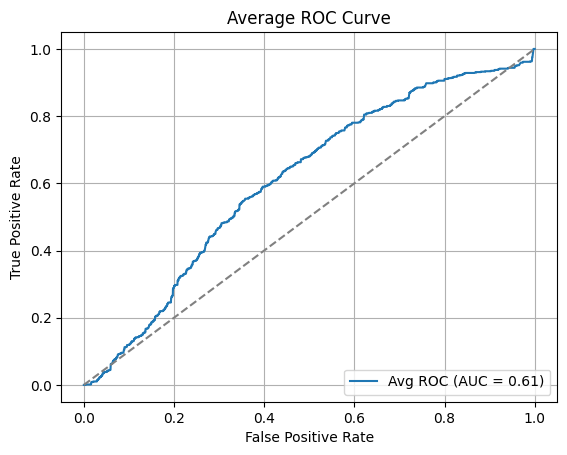

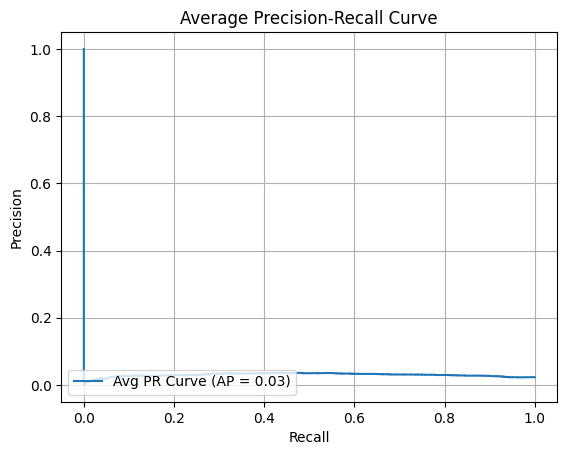

In [49]:
# Week level
all_y_true = []
all_y_probs = []
modelsSGK = []

for train_idx, val_idx in sgkf.split(x_week, targets_week, groups=groups_week):
    X_tr, y_tr = x_week.iloc[train_idx], targets_week.iloc[train_idx]
    X_vl, y_vl = x_week.iloc[val_idx], targets_week.iloc[val_idx]

    model, y_val, y_prob_val = train_evaluate(X_tr, y_tr, X_vl, y_vl, **best_params_week)

    all_y_true.append(y_val)
    all_y_probs.append(y_prob_val)
    modelsSGK.append(model)

# Concatenate all predictions
y_all = np.concatenate(all_y_true)
probs_all = np.concatenate(all_y_probs)

# ROC Curve
fpr, tpr, _ = roc_curve(y_all, probs_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Avg ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_all, probs_all)
avg_precision = average_precision_score(y_all, probs_all)

plt.figure()
plt.plot(recall, precision, label=f'Avg PR Curve (AP = {avg_precision:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

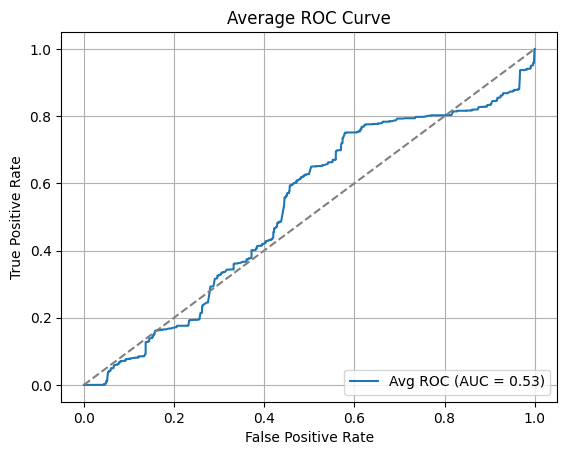

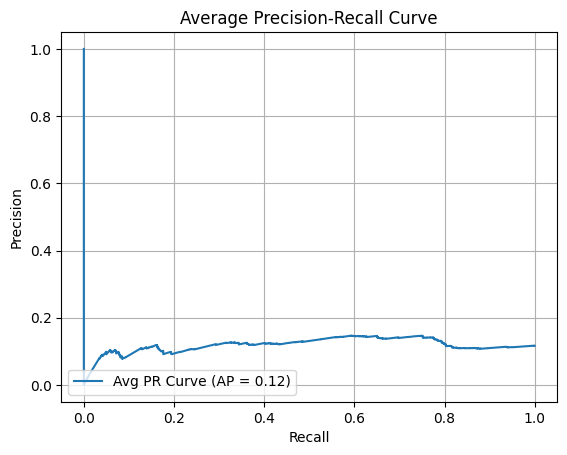

In [50]:
# User level
all_y_true = []
all_y_probs = []
modelsSGK = []

for train_idx, val_idx in sgkf.split(x_user, targets_user, groups=groups_user):
    X_tr, y_tr = x_user.iloc[train_idx], targets_user.iloc[train_idx]
    X_vl, y_vl = x_user.iloc[val_idx], targets_user.iloc[val_idx]

    model, y_val, y_prob_val = train_evaluate(X_tr, y_tr, X_vl, y_vl, **best_params_user)

    all_y_true.append(y_val)
    all_y_probs.append(y_prob_val)
    modelsSGK.append(model)

# Concatenate all predictions
y_all = np.concatenate(all_y_true)
probs_all = np.concatenate(all_y_probs)

# ROC Curve
fpr, tpr, _ = roc_curve(y_all, probs_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Avg ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_all, probs_all)
avg_precision = average_precision_score(y_all, probs_all)

plt.figure()
plt.plot(recall, precision, label=f'Avg PR Curve (AP = {avg_precision:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

## 3) Threshold Tuning

In [54]:
def youden_index_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    if cm.shape != (2, 2):
        return 0.0  # fallback if only one class is present
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    return sensitivity + specificity - 1

youden_scorer = make_scorer(youden_index_score)

In [55]:
# WEEK

# --- Model definition ---
model = XGBClassifier(
    **best_params_week,
    random_state=42,
    n_jobs=-1,
)

# --- Wrapper for threshold tuning ---
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=youden_scorer,   # score using Youden index
    store_cv_results=True,
    thresholds=200,
    refit=True
)

# --- Cross-validate outer loop ---
cv = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "youden": youden_scorer,
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "f1": make_scorer(f1_score),
    "accuracy": "accuracy",
    "roc_auc": "roc_auc"
}

cv_results_tuned_model = pd.DataFrame(
    cross_validate(
        tuned_model,
        x_week,          # your features
        targets_week,        # your binary labels
        groups=groups_week,  # same group used in StratifiedGroupKFold
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True
    )
)

# --- Summary of scores ---
cv_results_tuned_model[
    [col for col in cv_results_tuned_model.columns if "test" in col]
].aggregate(["mean", "std"]).T

,mean,std
test_youden,0.135849,0.193197
test_balanced_accuracy,0.567924,0.096598
test_f1,0.062386,0.037690
test_accuracy,0.568261,0.118260
test_roc_auc,0.590537,0.107002


In [56]:
thresholds = [est.best_threshold_ for est in cv_results_tuned_model["estimator"]]

# Mean (sensitive to outliers)
mean_threshold = np.mean(thresholds)

# Median (robust to outliers)
median_threshold = np.median(thresholds)

# Trimmed mean: excludes lowest/highest 10%
trimmed_threshold = trim_mean(thresholds, proportiontocut=0.1)

print(f"Mean threshold:     {mean_threshold:.3f}")
print(f"Median threshold:   {median_threshold:.3f}")
print(f"Trimmed threshold:  {trimmed_threshold:.3f}")

Mean threshold:     0.020
Median threshold:   0.021
Trimmed threshold:  0.020


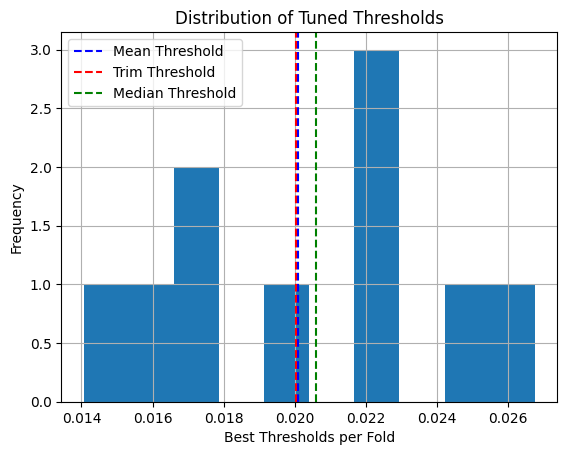

In [57]:
plt.hist(thresholds, bins=10)
plt.axvline(mean_threshold, color='blue', linestyle='--', label='Mean Threshold')
plt.axvline(trimmed_threshold, color='red', linestyle='--', label='Trim Threshold')
plt.axvline(median_threshold, color='green', linestyle='--', label='Median Threshold')
plt.xlabel("Best Thresholds per Fold")
plt.ylabel("Frequency")
plt.title("Distribution of Tuned Thresholds")
plt.legend()
plt.grid(True)
plt.show()

In [61]:
week_thresh  = 0.021

In [58]:
# USER

# --- Model definition ---
model = XGBClassifier(
    **best_params_user,
    random_state=42,
    n_jobs=-1,
)

# --- Wrapper for threshold tuning ---
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=youden_scorer,   # score using Youden index
    store_cv_results=True,
    thresholds=200,
    refit=True
)

# --- Cross-validate outer loop ---
cv = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=42)
scoring = {
    "youden": youden_scorer,
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "f1": make_scorer(f1_score),
    "accuracy": "accuracy",
    "roc_auc": "roc_auc"
}

cv_results_tuned_model = pd.DataFrame(
    cross_validate(
        tuned_model,
        x_user,          # your features
        targets_user,        # your binary labels
        groups=groups_user,  # same group used in StratifiedGroupKFold
        scoring=scoring,
        cv=cv,
        return_train_score=True,
        return_estimator=True
    )
)

# --- Summary of scores ---
cv_results_tuned_model[
    [col for col in cv_results_tuned_model.columns if "test" in col]
].aggregate(["mean", "std"]).T

,mean,std
test_youden,-0.021295,0.119743
test_balanced_accuracy,0.489352,0.059872
test_f1,0.088807,0.086624
test_accuracy,0.651478,0.240274
test_roc_auc,0.501827,0.115398


In [59]:
thresholds = [est.best_threshold_ for est in cv_results_tuned_model["estimator"]]

# Mean (sensitive to outliers)
mean_threshold = np.mean(thresholds)

# Median (robust to outliers)
median_threshold = np.median(thresholds)

# Trimmed mean: excludes lowest/highest 10%
trimmed_threshold = trim_mean(thresholds, proportiontocut=0.1)

print(f"Mean threshold:     {mean_threshold:.3f}")
print(f"Median threshold:   {median_threshold:.3f}")
print(f"Trimmed threshold:  {trimmed_threshold:.3f}")

Mean threshold:     0.205
Median threshold:   0.157
Trimmed threshold:  0.197


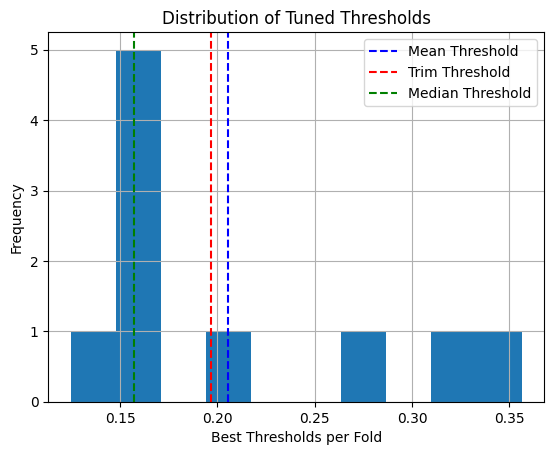

In [60]:
plt.hist(thresholds, bins=10)
plt.axvline(mean_threshold, color='blue', linestyle='--', label='Mean Threshold')
plt.axvline(trimmed_threshold, color='red', linestyle='--', label='Trim Threshold')
plt.axvline(median_threshold, color='green', linestyle='--', label='Median Threshold')
plt.xlabel("Best Thresholds per Fold")
plt.ylabel("Frequency")
plt.title("Distribution of Tuned Thresholds")
plt.legend()
plt.grid(True)
plt.show()

In [62]:
user_thresh  = 0.157

## 4) Evaluating Threshold

In [69]:
def evaluate_threshold_with_cv(params, threshold, X, y, groups, n_splits=5):
    """
    Trains and evaluates a model using CV at a specified threshold.

    Parameters:
    - params: dict of hyperparameters for XGBClassifier
    - threshold: float, probability threshold for classification
    - X, y: features and binary labels
    - groups: group labels for StratifiedGroupKFold
    - n_splits: number of CV splits

    Returns:
    - pd.DataFrame with per-fold metrics and overall average
    """
    cv = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=42)
    metrics = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y, groups)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = XGBClassifier(**params, eval_metric='logloss', n_jobs=-1, random_state=42)
        model.fit(X_train, y_train)

        y_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_proba >= threshold).astype(int)

        cm = confusion_matrix(y_val, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        else:
            specificity = 0

        recall = recall_score(y_val, y_pred, zero_division=0)
        youden = recall + specificity - 1

        metrics.append({
            "fold": fold,
            "accuracy": accuracy_score(y_val, y_pred),
            "precision": precision_score(y_val, y_pred, zero_division=0),
            "recall": recall,
            "specificity": specificity,
            "f1": f1_score(y_val, y_pred, zero_division=0),
            "roc_auc": roc_auc_score(y_val, y_proba),
            "youden_index": youden
        })

    results_df = pd.DataFrame(metrics)
    avg_row = results_df.mean(numeric_only=True).to_dict()
    avg_row["fold"] = "mean"
    results_df = pd.concat([results_df, pd.DataFrame([avg_row])], ignore_index=True)

    return results_df


In [70]:
results_week = evaluate_threshold_with_cv(
    params=best_params_week,
    threshold=week_thresh,
    X=x_week,
    y=targets_week,
    groups=groups_week,
    n_splits=10
)

results_user = evaluate_threshold_with_cv(
    params=best_params_user,
    threshold=user_thresh,
    X=x_user,
    y=targets_user,
    groups=groups_user,
    n_splits=10
)

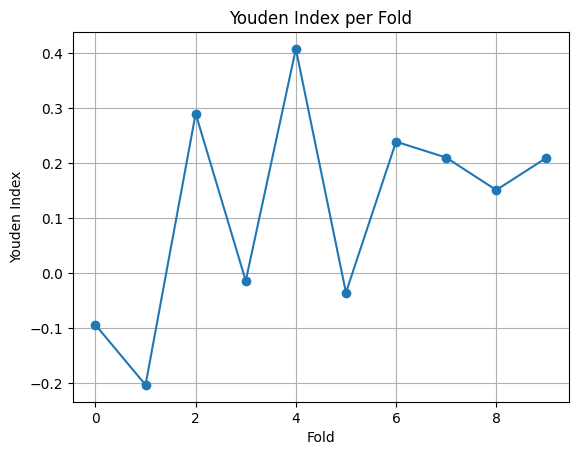

In [71]:
results_df_no_mean = results_week[results_week['fold'] != 'mean']

plt.plot(results_df_no_mean['fold'], results_df_no_mean['youden_index'], marker='o')
plt.title("Youden Index per Fold")
plt.xlabel("Fold")
plt.ylabel("Youden Index")
plt.grid(True)
plt.show()


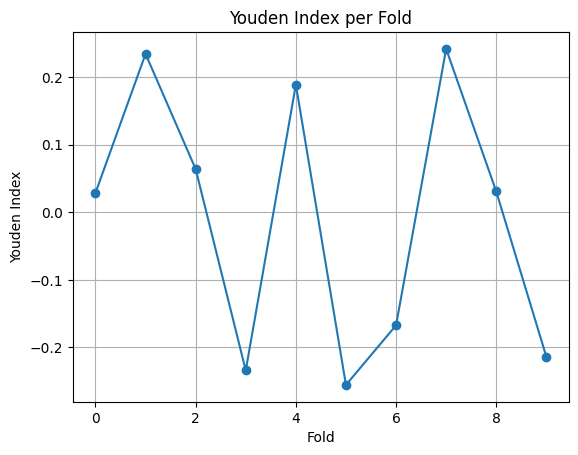

In [72]:
results_df_no_mean = results_user[results_user['fold'] != 'mean']

plt.plot(results_df_no_mean['fold'], results_df_no_mean['youden_index'], marker='o')
plt.title("Youden Index per Fold")
plt.xlabel("Fold")
plt.ylabel("Youden Index")
plt.grid(True)
plt.show()

In [73]:
# --- First fold split (week-level) ---
for train_idx, val_idx in sgkf.split(x_week, targets_week, groups_week):
    X_train_week, X_val_week = x_week.iloc[train_idx], x_week.iloc[val_idx]
    y_train_week = targets_week.iloc[train_idx]
    y_val_week = targets_week.iloc[val_idx]
    groups_train_week = groups_week.iloc[train_idx]
    break

# --- Train model ---
model_week = XGBClassifier(**best_params_week, n_jobs=-1, random_state=42, eval_metric='logloss')
model_week.fit(X_train_week, y_train_week)

# --- Predict probabilities on validation set ---
y_prob_week = model_week.predict_proba(X_val_week)[:, 1]

# --- Call compute_metrics ---
acc_week, auroc_week, auprc_week, cm_week = compute_metrics(y_val_week, y_prob_week, thresh=week_thresh)

# --- Print results ---
print(f"Accuracy:  {acc_week:.3f}")
print(f"AUROC:     {auroc_week:.3f}")
print(f"AUPRC:     {auprc_week:.3f}")
print("Confusion Matrix:")
print(cm_week)


Accuracy:  0.762
AUROC:     0.818
AUPRC:     0.126
Confusion Matrix:
[[2526  772]
 [  37   70]]


In [74]:
# --- First fold split (user-level) ---
for train_idx, val_idx in sgkf.split(x_user, targets_user, groups_user):
    X_train_user, X_val_user = x_user.iloc[train_idx], x_user.iloc[val_idx]
    y_train_user, y_val_user = targets_user.iloc[train_idx], targets_user.iloc[val_idx]
    groups_train_user = groups_user.iloc[train_idx]
    break

# --- Train model ---
model = XGBClassifier(**best_params_user, n_jobs=-1, random_state=42, eval_metric='logloss')
model.fit(X_train_user, y_train_user)

# --- Predict probabilities on validation set ---
y_prob_user = model.predict_proba(X_val_user)[:, 1]

# --- Call compute_metrics ---
acc, auroc, auprc, cm = compute_metrics(y_val_user, y_prob_user, thresh=user_thresh)

# --- Print results ---
print(f"Accuracy:  {acc:.3f}")
print(f"AUROC:     {auroc:.3f}")
print(f"AUPRC:     {auprc:.3f}")
print("Confusion Matrix:")
print(cm)


Accuracy:  0.595
AUROC:     0.413
AUPRC:     0.105
Confusion Matrix:
[[1978 1023]
 [ 341   28]]


## 5) No More Day Level

In [ ]:
user_flat = pd.read_csv('/content/data/user_flat.csv')

In [ ]:
two_week_flat = pd.read_csv('/content/data/two_week_flat.csv')

In [ ]:
two_week_flat

In [16]:
def select_window_columns(df, target_features, max_days=14):
    selected_cols = []

    for d in range(max_days):
        prefix = f'day{d}_'
        for feat in target_features:
            col = prefix + feat
            if col in df.columns:
                selected_cols.append(col)

    return selected_cols

In [24]:
x_week = two_week_flat[select_window_columns(two_week_flat, measure_features + one_h_features)]
targets_week = two_week_flat['visit_window']
groups_week = two_week_flat['fitbit_user_id']

x_user = user_flat[select_window_columns(user_flat, measure_features + one_h_features, 180)]
targets_user = user_flat['visit_any']

In [25]:
xgb = XGBClassifier(random_state=42, n_jobs=-1)
sgkf = StratifiedGroupKFold(n_splits=10)
skf = StratifiedKFold(n_splits=10)

In [27]:
cross_val_score(xgb, x_week, targets_week, groups=groups_week, cv=sgkf, scoring="roc_auc")

array([0.69769874, 0.51764706, 0.64705882, 0.74117647, 0.71597222,
       0.60167364, 0.68535565, 0.6144958 , 0.35609244, 0.67647059])

In [29]:
cross_val_score(xgb, x_user, targets_user, cv=skf, scoring="roc_auc")

array([0.47619048, 0.4047619 , 0.53968254, 0.22222222, 0.63492063,
       0.6031746 , 0.22222222, 0.6125    , 0.5375    , 0.55      ])

In [30]:
cross_val_score(xgb, x_week, targets_week, groups=groups_week, cv=sgkf, scoring="f1")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [31]:
cross_val_score(xgb, x_user, targets_user, cv=skf, scoring="f1")

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.28571429, 0.        , 0.        ])

In [32]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    cv=sgkf.split(x_week, targets_week, groups=groups_week),
    verbose=1,
    random_state=42
)

search.fit(x_week, targets_week, groups=groups_week)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
Best ROC AUC: 0.7233317926194187


In [33]:
best_params_week = {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 0.8}

In [37]:
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,
    scoring='roc_auc',
    n_jobs=-1,
    cv=skf.split(x_user, targets_user),
    verbose=1,
    random_state=42
)

search.fit(x_user, targets_user)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best params: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best ROC AUC: 0.5188888888888888


In [ ]:
best_params_user = {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.6}

In [34]:
def train_evaluate(X_train, y_train, X_val, y_val, **params):
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    y_prob_val = model.predict_proba(X_val)[:, 1]

    return model, y_val, y_prob_val

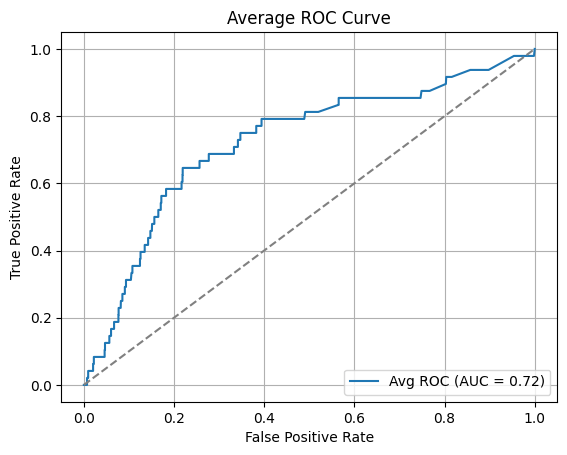

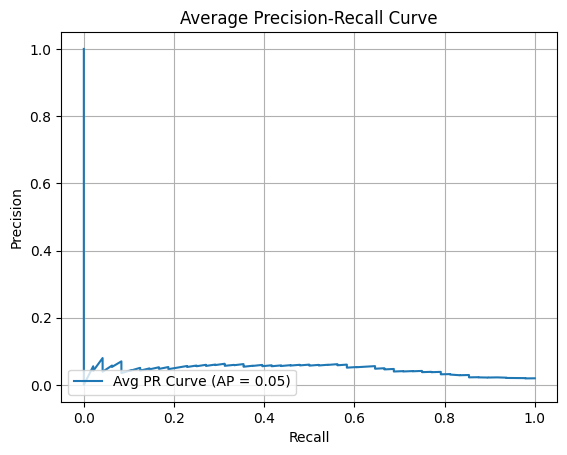

In [35]:
# Week level
all_y_true = []
all_y_probs = []
modelsSGK = []

for train_idx, val_idx in sgkf.split(x_week, targets_week, groups=groups_week):
    X_tr, y_tr = x_week.iloc[train_idx], targets_week.iloc[train_idx]
    X_vl, y_vl = x_week.iloc[val_idx], targets_week.iloc[val_idx]

    model, y_val, y_prob_val = train_evaluate(X_tr, y_tr, X_vl, y_vl, **best_params_week)

    all_y_true.append(y_val)
    all_y_probs.append(y_prob_val)
    modelsSGK.append(model)

# Concatenate all predictions
y_all = np.concatenate(all_y_true)
probs_all = np.concatenate(all_y_probs)

# ROC Curve
fpr, tpr, _ = roc_curve(y_all, probs_all)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Avg ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# PR Curve
precision, recall, _ = precision_recall_curve(y_all, probs_all)
avg_precision = average_precision_score(y_all, probs_all)

plt.figure()
plt.plot(recall, precision, label=f'Avg PR Curve (AP = {avg_precision:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Average Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()